# Task B -- Deep learning method

Import packages

In [1]:
import os
import pandas as pd
import numpy as np

# visualizing data
import matplotlib.pyplot as plt
%matplotlib inline


#data
from skimage import io, transform
from skimage.io import imread
from sklearn import metrics, datasets
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# import torch.nn.functional as F
import numpy as np
import math

In [2]:
#import torch
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import DataLoader
import torch.utils.model_zoo as model_zoo
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image

In [3]:
# train_on_gpu
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


Load image functions

In [4]:
# Tumor class: used for load images from folder and add lables
class Tumor(data.Dataset):
    def __init__(self,image_path = './dataset/image/', label_table = './dataset/label.csv'):
        self.image_path = image_path
        self.label_table = label_table
        self.dataset = pd.read_csv(label_table)
        self.category_dict = {'meningioma_tumor':0, 'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        self.label_dict = {0:'meningioma_tumor', 1:'glioma_tumor', 2:'pituitary_tumor', 3:'no_tumor'}
        self.transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()])
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        label = self.category_dict[str(self.dataset.iloc[index, 1])]
        imgPath = self.image_path + self.dataset.iloc[index, 0]
        img = Image.open(imgPath)
        img = self.transform(img)

        return img, label

Load images from folder and seperate to different sets for learning and testing

In [5]:
# batch size
batch_size=16

# define datasets using ImageFolder
training_dataset = Tumor()

# seperate data to three sets: training set, validataion set, and test set
length = len(training_dataset)

learning_size = int(0.8 * length)
test_size = length - learning_size
learning_set, test_set = torch.utils.data.random_split(training_dataset, [learning_size, test_size])

training_size = int(0.75 * learning_size)
validation_size = learning_size - training_size
training_set, validation_set = torch.utils.data.random_split(learning_set, [training_size, validation_size])

# create and return DataLoaders
num_workers=0
training_loader = DataLoader(dataset=training_set, batch_size=batch_size, 
                          shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, 
                          shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, 
                          shuffle=True, num_workers=num_workers)

print('Load data successful!')

Load data successful!


Classic CNN model: Resnet18

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample 
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) # here
        
        self.drop1 = nn.Dropout(0.5)
        self.dense1 = nn.Linear(32768, 128)

        self.drop2 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(128,4) #change channel 
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x) #rgb to gray scale
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        # print(x4.size())
        x = x4.view(x4.size(0), -1)
        # print(x.size())
        x = self.drop1(x)
        # print(x.size())
        x = self.dense1(x)
        
        x = self.drop2(x) # convert 
        x = self.dense2(x) #

        return  x # [x4, x3, x2, x1]


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        from collections import OrderedDict
        state_dict = model.state_dict()
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        for k, v in pretrained_state_dict.items():
            if k not in state_dict:
                continue
            state_dict[k] = v
        model.load_state_dict(state_dict)
    return model


Model selection

In [7]:
model = resnet18()

if train_on_gpu:
    model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Train the model resnet18

In [8]:
#  num of epochs need to run
n_epochs = 50

# initialize minimum validation loss
min_valid_loss = np.Inf 

train_loss_list = []
valid_loss_list = []

for epoch in range(n_epochs):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model    
    model.train()
    for data, target in training_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    # validate model
    model.eval()
    for data, target in validation_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    
    # calculate average losses
    train_loss = train_loss / len(training_loader.sampler)
    valid_loss = valid_loss / len(validation_loader.sampler)
    
    # save train loss and valid loss for analyzing
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
        
    # print epoch statistics 
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= min_valid_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        min_valid_loss,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18.pt')
        min_valid_loss = valid_loss
        print('Model saved.')

Epoch: 0 	 Training Loss: 8.763244 	 Validation Loss: 4.751360
Validation loss decreased (inf --> 4.751360).  Saving model ...
Model saved.
Epoch: 1 	 Training Loss: 3.085362 	 Validation Loss: 3.140636
Validation loss decreased (4.751360 --> 3.140636).  Saving model ...
Model saved.
Epoch: 2 	 Training Loss: 1.734961 	 Validation Loss: 3.848866
Epoch: 3 	 Training Loss: 1.316664 	 Validation Loss: 1.627699
Validation loss decreased (3.140636 --> 1.627699).  Saving model ...
Model saved.
Epoch: 4 	 Training Loss: 1.002243 	 Validation Loss: 1.065711
Validation loss decreased (1.627699 --> 1.065711).  Saving model ...
Model saved.
Epoch: 5 	 Training Loss: 0.822337 	 Validation Loss: 0.669828
Validation loss decreased (1.065711 --> 0.669828).  Saving model ...
Model saved.
Epoch: 6 	 Training Loss: 0.720985 	 Validation Loss: 0.813268
Epoch: 7 	 Training Loss: 0.685122 	 Validation Loss: 1.109852
Epoch: 8 	 Training Loss: 0.536948 	 Validation Loss: 0.969297
Epoch: 9 	 Training Loss: 0.

Plot loss vs. epochs

Text(0, 0.5, 'Loss')

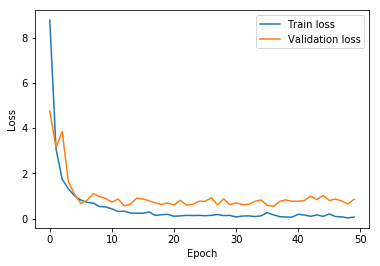

In [9]:
plt.plot(train_loss_list, label='Train loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Test the saved model

Classification report for resnet18:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       166
           1       0.76      0.91      0.83       142
           2       0.97      0.95      0.96       178
           3       0.97      0.80      0.88       114

    accuracy                           0.86       600
   macro avg       0.88      0.86      0.86       600
weighted avg       0.87      0.86      0.87       600


The accuracy is 86.5%.


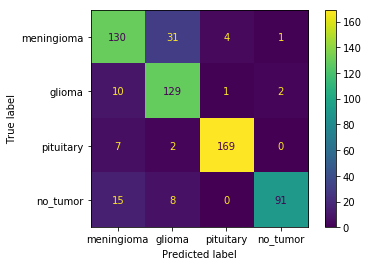

In [10]:
# initialize predict and true result
y_pred = []
y_test = []

# test the saved model
model.load_state_dict(torch.load('resnet18.pt'))
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    
    y_pred += target.tolist()
    y_test += pred.tolist()

    
print("Classification report for resnet18:\n{}\n".format(metrics.classification_report(y_test, y_pred)))
print(f"The accuracy is {accuracy_score(y_pred,y_test)*100}%.")

category = [0, 1, 2, 3]
# make confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=category)
category_disp = ['meningioma', 'glioma', 'pituitary', 'no_tumor']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_disp)
disp.plot()
